## 1 Python Configuration and Data Loading


Please follow the instructions below to ensure your Python environment is configured properly, and you are able to successfully load the data provided with this homework.

In [1]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
from scipy import io
for data_name in ["mnist", "spam", "cifar10"]:
    data = io.loadmat("data/%s_data.mat" % data_name)
    print("\nloaded %s data!" % data_name)
    fields = "test_data", "training_data", "training_labels"
    for field in fields:
        print(field, data[field].shape)


loaded mnist data!
test_data (10000, 784)
training_data (60000, 784)
training_labels (60000, 1)

loaded spam data!
test_data (5857, 32)
training_data (5172, 32)
training_labels (5172, 1)

loaded cifar10 data!
test_data (10000, 3072)
training_data (50000, 3072)
training_labels (50000, 1)


## 2 Data Partitioning

Create a function to shuffle the whole dataset

In [2]:
import random
def shuffle_dataset(name):
    dataset = io.loadmat(f"data/{name}")
    training_data = dataset["training_data"]
    training_lable = dataset["training_labels"]
    dataset_size = training_data.shape[0]
    reindex = random.sample(range(dataset_size), dataset_size)
    return training_data[reindex], training_lable[reindex]

For the MNIST dataset, write code that sets aside 10,000 training images as a validation set.

In [3]:
# Shuffle the dataset
minist_training_data, minist_training_label = shuffle_dataset("mnist_data.mat")
minist_validation_X = minist_training_data[:10000]
minist_validation_y = minist_training_label[:10000]
minist_training_data = minist_training_data[10000:]
minist_training_label = minist_training_label[10000:]

For the spam dataset, write code that sets aside 20% of the training data as a validation set.

In [4]:
spam_training_data, spam_training_label = shuffle_dataset("spam_data.mat")
validation_rows = int(spam_training_data.shape[0] * 0.2)
spam_validation_X = spam_training_data[:validation_rows]
spam_validation_y = spam_training_label[:validation_rows]
spam_training_data = spam_training_data[validation_rows:]
spam_training_label = spam_training_label[validation_rows:]

For the CIFAR-10 dataset, write code that sets aside 5,000 training images as a validation set.

In [5]:
cifar_training_data, cifar_training_label = shuffle_dataset("cifar10_data.mat")
cifar_validation_X = cifar_training_data[:5000]
cifar_validation_y = cifar_training_label[:5000]
cifar_training_data = cifar_training_data[5000:]
cifar_training_label = cifar_training_label[5000:]

## 3 Support Vector Machines: Coding

We will use linear Support Vector Machines to classify our datasets. For images, we will use the simplest of features for classification: raw pixel brightness values. In other words, our feature vector for an image will be a row vector with all the pixel values concatenated in a row major (or column major) order.

In [17]:
from sklearn import svm
def calculate_accuracy(training_data, training_label, validation_data, validation_label ,training_sizes):
    svm_model = svm.SVC(kernel='linear')
    training_accuracy = []
    validation_accuracy = []
    for train_size in training_sizes:
        svm_model.fit(training_data[:train_size], training_label[:train_size].ravel())
        
        predict_training = svm_model.predict(training_data[:train_size])
        training_accuracy.append(sklearn.metrics.accuracy_score(predict_training, training_label[:train_size]))
        
        predict_validation = svm_model.predict(validation_data)
        validation_accuracy.append(sklearn.metrics.accuracy_score(predict_validation, validation_label.ravel()))
    return training_accuracy, validation_accuracy

In [18]:
def plot_accuracy(training_sizes,training_accuarcy, validation_accuracy, title):
    plt.plot(training_sizes, training_accuarcy, label="training accuracy", marker="*")
    plt.plot(training_sizes, validation_accuracy, label="validation accuracy", marker="*")
    plt.xlabel('number of training examples')
    plt.ylabel('accuracy')
    plt.title(f"{title} accuracy on the training and validation sets versus the number of training examples")
    plt.legend()

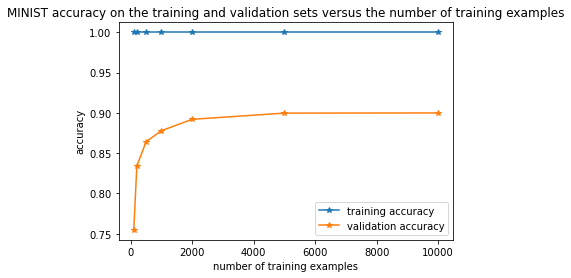

In [19]:
minist_training_accuracy, minist_validation_accuracy = calculate_accuracy(minist_training_data, minist_training_label, minist_validation_X, minist_validation_y, \
                   [100, 200, 500, 1000, 2000, 5000, 10000])
plot_accuracy([100, 200, 500, 1000, 2000, 5000, 10000], minist_training_accuracy, minist_validation_accuracy, "MINIST")

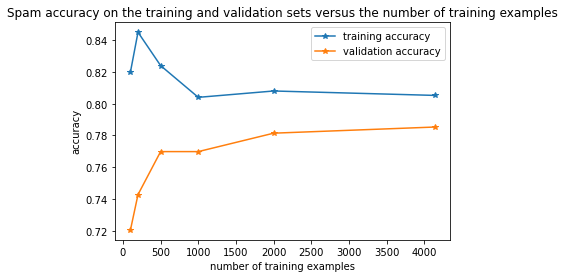

In [20]:
spam_training_accuracy, spam_validation_accuracy = calculate_accuracy(spam_training_data, spam_training_label, spam_validation_X, spam_validation_y,\
                                                                     [100, 200, 500, 1000, 2000, spam_training_data.shape[0]])
plot_accuracy([100, 200, 500, 1000, 2000, spam_training_data.shape[0]], spam_training_accuracy, spam_validation_accuracy, "Spam")

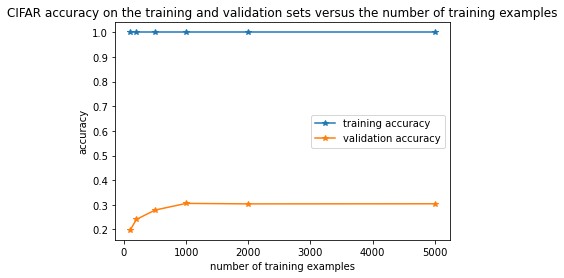

In [21]:
cifar_training_accuracy, cifar_validation_accuracy = calculate_accuracy(cifar_training_data, cifar_training_label, cifar_validation_X, cifar_validation_y,\
                                                                       [100, 200, 500, 1000, 2000, 5000])
plot_accuracy([100, 200, 500, 1000, 2000, 5000], cifar_training_accuracy, cifar_validation_accuracy, "CIFAR")

## 4 Hyperparameter Tuning

In the previous problem, you learned parameters for a model that classifies the data. Many clas- sifiers also have hyperparameters that you can tune to influence the parameters. In this problem, we’ll determine good values for the regularization parameter C in the soft-margin SVM algorithm.

When we are trying to choose a hyperparameter value, we train the model repeatedly with different hyperparameters. We select the hyperparameter that gives the model with the highest accuracy on the validation dataset. Before generating predictions for the test set, the model should be retrained using all the labeled data (including the validation data) and the previously-determined hyperpa- rameter.

**The use of automatic hyperparameter optimization libraries is prohibited for this part of the homework.**
- (a) For the MNIST dataset, find the best C value. In your report, list at least 8 C values you tried, the corresponding accuracies, and the best C value. As in the previous problem, for performance reasons, you are required to train with up to 10,000 training examples but not required to train with more than that.

In [29]:
# try different Cs, 10000 trainning examples
# mnist_c_list = [i for i in range(10000000, 10000001)]
mnist_c_list = [1e-07,2.5e-07, 5e-07, 7.5e-07, 1e-06,2.5e-06, 5e-06, 7.5e-06, 1e-05]
mnist_clf_c_list = []
for mnist_c in mnist_c_list:
    mnist_clf= svm.SVC(kernel='linear', C=mnist_c, max_iter=100000)
    mnist_clf.fit(minist_training_data[:10000,:], minist_training_label[:10000,:])
    mnist_clf_c_list.append(mnist_clf)
    print("TRAIN SUCCESS: C=" + str(mnist_c))

/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TRAIN SUCCESS: C=1e-07


/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TRAIN SUCCESS: C=2.5e-07


/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TRAIN SUCCESS: C=5e-07


/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TRAIN SUCCESS: C=7.5e-07


/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TRAIN SUCCESS: C=1e-06


/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TRAIN SUCCESS: C=2.5e-06


/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TRAIN SUCCESS: C=5e-06


/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TRAIN SUCCESS: C=7.5e-06


/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


TRAIN SUCCESS: C=1e-05


PREDICT SUCCESS: 1e-07: 0.9172
PREDICT SUCCESS: 2.5e-07: 0.9213
PREDICT SUCCESS: 5e-07: 0.9237
PREDICT SUCCESS: 7.5e-07: 0.9252
PREDICT SUCCESS: 1e-06: 0.9232
PREDICT SUCCESS: 2.5e-06: 0.919
PREDICT SUCCESS: 5e-06: 0.9144
PREDICT SUCCESS: 7.5e-06: 0.9113
PREDICT SUCCESS: 1e-05: 0.9091
best_c:7.5e-07
best_validation_accuracy:0.9252
PLOT SUCCESS!


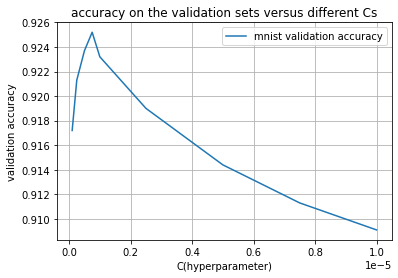

In [30]:
# find highest accuracy on validation sets
best_c = 0
best_validation_accuracy = 0
mnist_clf_validation_accuracy_list = []
for i in range(0, len(mnist_clf_c_list)):
    mnist_clf_validation_accuracy = mnist_clf_c_list[i].score(minist_validation_X, minist_validation_y)
    mnist_clf_validation_accuracy_list.append(mnist_clf_validation_accuracy)
    if mnist_clf_validation_accuracy > best_validation_accuracy:
        best_c = mnist_c_list[i]
        best_validation_accuracy = mnist_clf_validation_accuracy
    print("PREDICT SUCCESS: " + str(mnist_c_list[i]) + ": " + str(mnist_clf_validation_accuracy))
print("best_c:" + str(best_c))
print("best_validation_accuracy:" + str(best_validation_accuracy))
    
# plot
plt.plot(mnist_c_list, mnist_clf_validation_accuracy_list, label='mnist validation accuracy')

plt.xlabel('C(hyperparameter)')
plt.ylabel('validation accuracy')
plt.title("accuracy on the validation sets versus different Cs")
plt.grid(True)
plt.legend()

print('PLOT SUCCESS!')

### 5 K-Fold Cross-Validation
For smaller datasets (e.g., the spam dataset), the validation set contains fewer examples, and our estimate of our error might not be accurate—the estimate has high variance. A way to combat this is to use k-fold cross-validation.

In k-fold cross-validation, the training data is shuﬄed and partitioned into k disjoint sets. Then the model is trained on k − 1 sets and validated on the kth set. This process is repeated k times with each set chosen as the validation set once. The cross-validation accuracy we report is the accuracy averaged over the k iterations. Use of automatic cross-validation libraries is prohibited for this part of the homework.

(a) For the spam dataset, use 5-fold cross-validation to find and report the best C value. In your report, list at least 8 C values you tried, the corresponding accuracies, and the best C value.

Hint: Eﬀective cross-validation requires choosing from random partitions. This is best imple-mented by randomly shuﬄing your training examples and labels, then partitioning them by their indices.

In [107]:
def get_shuffle_index(shuffled_indexs, k, index):
    each_set = round(len(shuffled_indexs) / k)
    return shuffled_indexs[each_set * index : each_set * (index + 1)], shuffled_indexs[0: each_set * index] + shuffled_indexs[each_set * (index + 1) + 1 : ]


1:0.8030547075130714
2:0.804261852124785
4:0.8042624369816705
6:0.8049870746628299
7:0.8052286205565498
8:0.8054707513071552
best_c:8
best_cross_validation_accuracy:0.8054707513071552
PLOT SUCCESS!


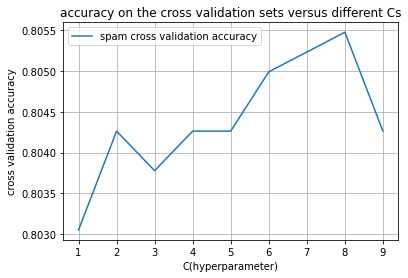

In [111]:
shuffled_indexs = random.sample(range(len(spam_training_data)), len(spam_training_data))
best_cross_validation_accuracy = 0
spam_clf_cross_validation_accuracy_list = []
k = 5
spam_c_list = list(range(1, 10))
for spam_c in spam_c_list:
    sum_accuracy = 0
    for i in range(0, k):
        validation_index, trainning_index = get_shuffle_index(shuffled_indexs, k, i)
        spam_clf= svm.SVC(kernel='linear', C=spam_c, max_iter=10000000)
        spam_training_set_data_partition = spam_training_data[trainning_index]
        spam_training_set_labels_partition = spam_training_label[trainning_index]
        spam_clf.fit(spam_training_set_data_partition, spam_training_set_labels_partition.ravel())
        sum_accuracy += spam_clf.score(spam_training_data[validation_index], spam_training_label[validation_index].ravel())
    avg_accuracy = sum_accuracy / float(k)
    spam_clf_cross_validation_accuracy_list.append(avg_accuracy)
    if best_cross_validation_accuracy < avg_accuracy:
        best_cross_validation_accuracy = avg_accuracy
        best_c = spam_c
        print(str(spam_c) + ":" + str(avg_accuracy))
        
print("best_c:" + str(best_c))
print("best_cross_validation_accuracy:" + str(best_cross_validation_accuracy))

# plot
plt.plot(spam_c_list, spam_clf_cross_validation_accuracy_list, label='spam cross validation accuracy')

plt.xlabel('C(hyperparameter)')
plt.ylabel('cross validation accuracy')
plt.title("accuracy on the cross validation sets versus different Cs")
plt.grid(True)
plt.legend()

print('PLOT SUCCESS!')